# SENIOR PROJECT

## Multi-Modal Sentiment and Emotion Classification Model

### TensorFlow GPU Configuration

This block configures TensorFlow to use available GPU resources more efficiently:

* **Enables memory growth** for all detected GPUs using `tf.config.experimental.set_memory_growth()`. This prevents TensorFlow from allocating all GPU memory upfront, allowing for more flexible and efficient memory usage—especially helpful when running multiple models or notebooks in parallel.
* **Device Check**: Prints whether TensorFlow is currently set to run on a **GPU** or **CPU**, based on available hardware.

This setup is recommended when working with deep learning models to ensure stable execution and better utilization of available GPU resources.

In [ ]:
# Enable GPU memory growth
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print("Memory growth enabled for GPUs.")

# Check device availability
print("Running on:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

Memory growth enabled for GPUs.
Running on: GPU


### Verifying GPU Availability with `nvidia-smi`

This command checks whether a **NVIDIA GPU** is properly allocated to the current runtime environment:

* `!nvidia-smi` displays real-time GPU usage, driver version, and hardware details (e.g., **Tesla T4**, **A100**).
* This helps confirm that your notebook is running with GPU acceleration enabled, which is essential for efficient deep learning model training and inference.

Use this check before training to ensure the environment is correctly configured.

In [ ]:
!nvidia-smi  # Verify GPU is active (e.g., T4 or A100)

Sat May  3 15:58:56 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### Mounting Google Drive

This command mounts your **Google Drive** to the Colab environment:

* `drive.mount('/content/drive')` gives the notebook access to files stored in your Drive.
* This is essential for loading datasets, saving trained models, or accessing other project assets persistently across sessions.

After mounting, files can be accessed using standard file paths prefixed with `/content/drive/`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Loading and Preprocessing the FER-2013 Dataset (CSV Format)

This section loads the **FER-2013** facial expression dataset from a CSV file stored in Google Drive and prepares it for training:

* **Loading**: The CSV file is read into a Pandas DataFrame using `pd.read_csv()`.
* **Label Mapping**: Numeric emotion labels (0–6) are mapped to human-readable names using a dictionary:

  * `angry`, `disgust`, `fear`, `happy`, `sad`, `surprise`, `neutral`
* **Pixel Conversion**:

  * The `pixels` column contains strings of grayscale pixel values (space-separated).
  * Each string is converted into a `48×48` NumPy array and normalized to the `[0, 1]` range.
* **Filtering**: Only samples labeled as `Training` in the `Usage` column are retained for model training.

This processed DataFrame (`fer_df`) is now ready for use in model training or further transformation.

In [ ]:
import pandas as pd
import numpy as np

# Load FER-2013
fer_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SENIOR PROJECT/fer-2013/fer-2013-csv/fer2013.csv')

# Map labels
emotion_map = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}
fer_df['emotion_label'] = fer_df['emotion'].map(emotion_map)
fer_df['pixels'] = fer_df['pixels'].apply(lambda x: np.array(x.split(), dtype='float32').reshape(48, 48) / 255.0)
fer_df = fer_df[fer_df['Usage'] == 'Training'].copy()


### Loading and Cleaning the Sentiment140 Dataset

This section prepares the **Sentiment140** dataset for text-based sentiment classification and fusion with FER-2013:

#### Load and Structure Data

* The raw CSV is loaded from Google Drive using `ISO-8859-1` encoding to handle special characters.
* Column headers are manually assigned for clarity: `target`, `ids`, `date`, `flag`, `user`, `text`.
* A new column `sentiment_label` is created by mapping:

  * `target = 0` → `'negative'`
  * `target = 4` → `'positive'`

#### Clean Text Data

* Text data is lowercased and cleaned using a custom regex function:

  * Removes URLs, mentions (`@user`), hashtags, and non-alphabetic characters.
  * This ensures input to the model is consistent and free from noise.

#### Sample for Fusion Dataset

* A balanced sample of `N = 10,000` rows is taken from both `fer_df` and `sentiment_df`.
* These samples will later be combined into a multi-modal dataset pairing facial expressions with matching sentiment captions for training a fusion model.

In [ ]:
sentiment_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/SENIOR PROJECT/sentiment140/training.1600000.processed.noemoticon.csv',
                           encoding='ISO-8859-1', header=None)

# Fix columns and clean
sentiment_df = sentiment_df.iloc[:, :6]
sentiment_df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
sentiment_df['sentiment_label'] = sentiment_df['target'].apply(lambda x: 'positive' if x == 4 else 'negative')


In [ ]:
import re
def clean_text(t): return re.sub(r'http\S+|@\w+|#[\w]+|[^a-z\s]', '', t.lower())

# Clean texts
sentiment_df['cleaned_text'] = sentiment_df['text'].apply(clean_text)

# Sample same count from both
N = 10000
fer_sample = fer_df.sample(n=N, random_state=42)
sentiment_sample = sentiment_df.sample(n=N, random_state=42)


### Preparing Inputs and Labels for Multimodal Fusion

This section transforms the sampled emotion and sentiment data into model-ready input tensors:

#### Image Input (`X_img`)

* Pixel arrays from `fer_sample` are stacked into a NumPy array and reshaped to `(N, 48, 48, 1)` for compatibility with CNN input layers.

#### Emotion Labels (`y_emotion`)

* Emotion strings are label-encoded and one-hot encoded using `LabelEncoder` and `to_categorical`, producing a 5-class categorical target.

#### Text Input (`X_txt`)

* Texts from `sentiment_sample` are cleaned, tokenized, and padded:

  * A `Tokenizer` is fitted on the text data (with a vocabulary limit of 10,000).
  * Sequences are padded to a uniform length of 100 tokens.

#### Sentiment Labels (`y_sentiment`)

* Sentiment labels (positive/negative) are also label-encoded and converted to 2-class one-hot vectors.

This prepares all components needed for training a **multimodal model** that accepts both facial image and textual caption as input, and predicts both emotion and sentiment as output.

In [ ]:
# X image input
X_img = np.stack(fer_sample['pixels'].values).reshape(-1, 48, 48, 1)

# Y emotion label (for CNN training, optional)
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
emotion_enc = LabelEncoder()
y_emotion = to_categorical(emotion_enc.fit_transform(fer_sample['emotion_label']))

# Text input
texts = sentiment_sample['cleaned_text'].tolist()

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
X_txt = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=100, padding='post')

# Sentiment labels
sentiment_enc = LabelEncoder()
y_sentiment = to_categorical(sentiment_enc.fit_transform(sentiment_sample['sentiment_label']))


### Building and Training a Basic Multimodal Fusion Model (Image + Text → Sentiment)

This section defines and trains a **dual-input deep learning model** that uses both image and text data to predict **sentiment only**.

---

#### Model Architecture

**Image Branch**:

* Input shape: `(48, 48, 1)` (grayscale facial image).
* Two convolutional layers with ReLU activations and MaxPooling.
* Flattened output is passed to a dense layer to produce a 64-dimensional image feature vector.

**Text Branch**:

* Input: tokenized text sequences of length 100.
* Embedding layer followed by a two-layer LSTM stack:

  * First LSTM returns sequences for deeper processing.
  * Second LSTM outputs a 64-dimensional vector.
* Output passed through a dense layer to produce text features.

**Fusion**:

* The image and text vectors are concatenated.
* Final layers:

  * Dropout → Dense (64 units) → Softmax (2 output units for binary sentiment classification).

The model is compiled with:

* `categorical_crossentropy` loss (for one-hot targets).
* `adam` optimizer.
* `accuracy` metric.

---

#### Model Training

* Data is split into training and validation sets (90/10 split).
* The fusion model is trained for **10 epochs** with a batch size of **64**.
* Inputs: both image and text branches receive data simultaneously.
* Outputs: model predicts binary sentiment (positive or negative).

This setup serves as a baseline for text+image sentiment fusion, and can be extended to include emotion outputs in a full multi-task setup.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Embedding, LSTM, Concatenate

# Image branch
image_input = Input(shape=(48, 48, 1))
x = Conv2D(32, (3,3), activation='relu')(image_input)
x = MaxPooling2D(2,2)(x)
x = Dropout(0.3)(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = MaxPooling2D(2,2)(x)
x = Flatten()(x)
image_output = Dense(64, activation='relu')(x)

# Text branch
text_input = Input(shape=(100,))
y = Embedding(input_dim=10000, output_dim=128)(text_input)
y = LSTM(128, return_sequences=True)(y)
y = Dropout(0.3)(y)
y = LSTM(64)(y)
text_output = Dense(64, activation='relu')(y)

# Merge + Head
combined = Concatenate()([image_output, text_output])
z = Dropout(0.3)(combined)
z = Dense(64, activation='relu')(z)
output = Dense(2, activation='softmax')(z)

fusion_model = Model(inputs=[image_input, text_input], outputs=output)
fusion_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from sklearn.model_selection import train_test_split

X_img_train, X_img_val, X_txt_train, X_txt_val, y_train, y_val = train_test_split(
    X_img, X_txt, y_sentiment, test_size=0.1, random_state=42
)

fusion_model.fit([X_img_train, X_txt_train], y_train,
                 validation_data=([X_img_val, X_txt_val], y_val),
                 epochs=10,
                 batch_size=64)


Epoch 1/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.5058 - loss: 0.6953 - val_accuracy: 0.4960 - val_loss: 0.6933
Epoch 2/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4960 - loss: 0.6936 - val_accuracy: 0.4960 - val_loss: 0.6933
Epoch 3/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5015 - loss: 0.6935 - val_accuracy: 0.4960 - val_loss: 0.6943
Epoch 4/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.4947 - loss: 0.6932 - val_accuracy: 0.4960 - val_loss: 0.6935
Epoch 5/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5045 - loss: 0.6935 - val_accuracy: 0.4940 - val_loss: 0.6932
Epoch 6/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5075 - loss: 0.6932 - val_accuracy: 0.5020 - val_loss: 0.6934
Epoch 7/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5047 - loss: 0.6925 - val_accuracy: 0.4900 - val_loss: 0.6950
Epoch 8/10
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5233 - loss: 0.6912 - val_acc

### Image Augmentation for Model Robustness

This block sets up **real-time data augmentation** for the facial image inputs using `ImageDataGenerator`:

* **Purpose**: To improve generalization by exposing the model to varied versions of the training data.

* **Transformations Applied**:

  * `rotation_range=10`: Randomly rotates images up to 10 degrees.
  * `zoom_range=0.1`: Random zoom in/out by 10%.
  * `width_shift_range=0.1`: Shifts image horizontally by 10% of width.
  * `height_shift_range=0.1`: Shifts image vertically by 10% of height.
  * `horizontal_flip=True`: Randomly flips images horizontally.

* `datagen.fit(X_img)`: Precomputes any necessary statistics (e.g., mean, std) for normalization if needed.

This augmentation pipeline can be applied during training to artificially expand the dataset and reduce overfitting.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_img)


### Defining a Deep CNN for FER-2013 Emotion Classification (7 Classes)

This block builds a deep **Convolutional Neural Network (CNN)** to classify facial expressions into 7 categories from the FER-2013 dataset.

#### Model Architecture

The architecture is defined using Keras `Sequential` API:

* **Convolutional Layers**:

  * Four Conv2D blocks progressively increase the number of filters (32 → 256).
  * Each block includes:

    * `Conv2D` with ReLU activation
    * `BatchNormalization` to stabilize training
    * `MaxPooling2D` to reduce spatial dimensions
    * `Dropout` for regularization (25% drop rate)

* **Fully Connected Layers**:

  * Flattened output is passed to:

    * A dense layer with 256 units and ReLU
    * Final `Dropout(0.5)` for strong regularization
    * Output layer with **7 softmax units** corresponding to the 7 emotion classes:
      `angry`, `disgust`, `fear`, `happy`, `sad`, `surprise`, `neutral`

#### Compilation

* **Loss**: `categorical_crossentropy` (for one-hot encoded labels)
* **Optimizer**: `adam`
* **Metrics**: Tracks `accuracy` during training and evaluation

This CNN is designed for robust performance on challenging facial expression data with moderate depth and regularization.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Training the CNN with Augmentation and Callbacks

This section trains the previously defined 7-class emotion classification CNN using augmented image data and training callbacks to optimize performance and prevent overfitting.

#### Data Split

* Splits the processed FER-2013 dataset into **90% training** and **10% validation** using `train_test_split`.

#### Data Augmentation

* Applies real-time image transformations using the `datagen` pipeline (defined earlier) to artificially expand the training set and improve generalization.

#### Training Callbacks

* `EarlyStopping`: Halts training if validation loss does not improve for 5 consecutive epochs. Restores the best weights.
* `ReduceLROnPlateau`: Reduces learning rate by a factor of 0.2 if validation loss plateaus for 3 epochs. Prevents overshooting local minima.

#### Model Training

* Trained for up to **50 epochs** using a batch size of **64**.
* `fit()` receives the augmented training data via `datagen.flow()` and validates on the untouched `X_val` set.
* The `history` object records performance metrics across all epochs for later visualization.

This setup ensures the CNN is trained efficiently and safely, with adaptive learning and early stopping strategies in place.

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

X_train, X_val, y_train, y_val = train_test_split(X_img, y_emotion, test_size=0.1, random_state=42)

history = model.fit(datagen.flow(X_train, y_train, batch_size=64),
                    validation_data=(X_val, y_val),
                    epochs=50,
                    callbacks=[early_stop, lr_scheduler])


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


141/141 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.2036 - loss: 2.4890 - val_accuracy: 0.1680 - val_loss: 1.9708 - learning_rate: 0.0010
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.2388 - loss: 1.8419 - val_accuracy: 0.2720 - val_loss: 1.9680 - learning_rate: 0.0010
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.2483 - loss: 1.7982 - val_accuracy: 0.2230 - val_loss: 1.8279 - learning_rate: 0.0010
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.2837 - loss: 1.7572 - val_accuracy: 0.2600 - val_loss: 1.7827 - learning_rate: 0.0010
Epoch 5/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3080 - loss: 1.7010 - val_accuracy: 0.3330 - val_loss: 1.6818 - learning_rate: 0.0010
Epoch 6/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.3481 - loss: 1.6598 - val_accuracy: 0.2670 - val_loss: 2.9266 - learning_rate: 0.0010
Epoch 7/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.3489 - loss: 1.6355 - val

### Save the model

Here we keep this to save the best performing models and overwrite them.

In [ ]:
model.save('/content/drive/MyDrive/fusion_cnn_model.keras')


### Visualizing CNN Training Performance

This section plots the **training and validation accuracy and loss curves** over the course of training to assess the model's learning behavior.

#### Accuracy Plot

* Shows how well the model correctly classifies training and validation samples over each epoch.
* Helps detect signs of **underfitting** (low accuracy) or **overfitting** (large gap between training and validation curves).

#### Loss Plot

* Displays how the training and validation loss evolve during training.
* A stable decrease in both indicates good learning, while divergence suggests overfitting or poor generalization.

These visualizations are essential for evaluating model convergence and making informed decisions about architecture, training duration, or regularization.

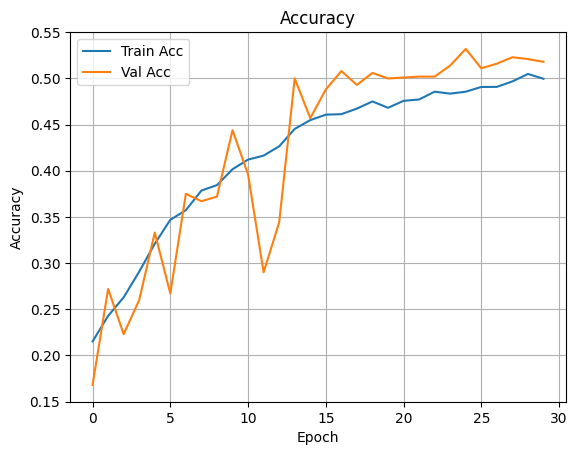

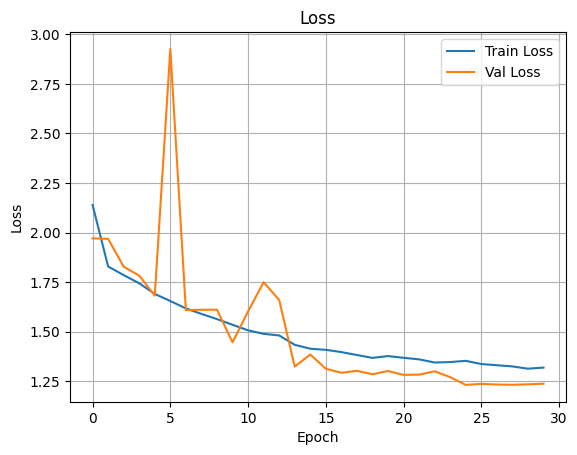

(None, None)

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(), plt.title('Accuracy')
plt.xlabel('Epoch'), plt.ylabel('Accuracy')
plt.grid(), plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(), plt.title('Loss')
plt.xlabel('Epoch'), plt.ylabel('Loss')
plt.grid(), plt.show()


### Evaluate Emotion Model on Test Set

Splits the image-based emotion dataset into training and test sets, and evaluates the model's accuracy and loss on the test split. This helps validate the model’s generalization ability on unseen emotion images.

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming X_img and y_emotion are your full dataset
X_train, X_test, y_train, y_test = train_test_split(X_img, y_emotion, test_size=0.2, random_state=42) # Create a test set

# Now you can evaluate:
model.evaluate(X_test, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5431 - loss: 1.2019


[1.1655895709991455, 0.5584999918937683]

### Preparing CNN and NLP Models for Fusion

This section loads a pretrained CNN model for image features and builds a new text-only sentiment classifier using an LSTM-based NLP model. Both components will later be used in a fusion architecture.

---

#### Load and Freeze Trained CNN

* Loads a previously trained CNN model (`fusion_cnn_model.keras`) for image-based emotion features.
* All layers are set to **non-trainable** to freeze their weights for transfer learning.
* A dummy input is passed to ensure the model is built and has accessible input/output tensors (`cnn_model.input`, `cnn_model.output`).

---

#### Balance Sentiment Dataset

* Samples 10,000 **positive** and 10,000 **negative** sentiment examples from the cleaned Sentiment140 dataset.
* Combines them into a **balanced binary classification dataset** for training the NLP model.

---

#### Text Preprocessing and Label Encoding

* Tokenizes the cleaned text into padded sequences of integers using Keras' `Tokenizer`.
* Limits vocabulary to 10,000 words and pads/truncates to 100 tokens.
* Sentiment labels (`positive`, `negative`) are label-encoded and one-hot encoded using `LabelEncoder` and `to_categorical`.

---

#### Train/Validation Split

* Splits the processed text and labels into training and validation sets (90%/10%) for supervised learning.

---

#### Define and Train LSTM-Based Sentiment Classifier

* Constructs a **Sequential NLP model** with:

  * An `Embedding` layer to learn word embeddings
  * Two stacked `LSTM` layers for sequential context
  * Fully connected layers with `ReLU` activation and dropout
  * Final softmax output for binary sentiment classification
* Compiled with the **Adam optimizer** and **categorical crossentropy loss**
* Trained for **10 epochs** with a batch size of **64**

This text-only model captures sentiment representations from captions, complementing the CNN's visual understanding for future multimodal fusion.

In [ ]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate

# Load trained CNN
cnn_model = load_model('/content/drive/MyDrive/fusion_cnn_model.keras')
for layer in cnn_model.layers:
    layer.trainable = False

# Call the model with a dummy input to build it
# This will create the `input` attribute
cnn_model(Input(shape=(48, 48, 1)))

image_input = cnn_model.input
cnn_output = cnn_model.output

In [ ]:
pos_samples = sentiment_df[sentiment_df['sentiment_label'] == 'positive'].sample(10000, random_state=42)
neg_samples = sentiment_df[sentiment_df['sentiment_label'] == 'negative'].sample(10000, random_state=42)

balanced_df = pd.concat([pos_samples, neg_samples])


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

texts = balanced_df['cleaned_text'].tolist()
labels = balanced_df['sentiment_label'].tolist()

tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)
X_text = pad_sequences(sequences, maxlen=100, padding='post')

label_enc = LabelEncoder()
y_text = to_categorical(label_enc.fit_transform(labels))  # 0 = neg, 1 = pos


In [ ]:
from sklearn.model_selection import train_test_split

X_text_train, X_text_val, y_text_train, y_text_val = train_test_split(
    X_text, y_text, test_size=0.1, random_state=42
)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

nlp_model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=100),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')
])

nlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

nlp_model.fit(X_text_train, y_text_train,
              validation_data=(X_text_val, y_text_val),
              epochs=10,
              batch_size=64)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


282/282 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.4929 - loss: 0.6949 - val_accuracy: 0.4885 - val_loss: 0.6944
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4994 - loss: 0.6939 - val_accuracy: 0.5115 - val_loss: 0.6929
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4951 - loss: 0.6937 - val_accuracy: 0.5115 - val_loss: 0.6930
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4952 - loss: 0.6935 - val_accuracy: 0.4885 - val_loss: 0.6934
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4998 - loss: 0.6933 - val_accuracy: 0.4885 - val_loss: 0.6934
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4990 - loss: 0.6933 - val_accuracy: 0.4885 - val_loss: 0.6932
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4999 - loss: 0.6933 - val_accuracy: 0.4885 - val_loss: 0.6932
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4894 - loss: 0.6932 - val_accuracy: 0.511

### Evaluating Individual Model Performance (CNN & NLP)

This section evaluates the performance of the two trained models independently on their respective tasks:

#### CNN Model — Emotion Classification

* The pretrained and frozen **CNN model** is evaluated on a held-out test set of facial images.
* Prints the **emotion classification accuracy** based on the model’s softmax predictions.

#### LSTM Model — Sentiment Classification

* The trained **NLP model** (`nlp_model`) is evaluated on a separate test set of cleaned and tokenized text inputs.
* Prints the **sentiment classification accuracy**.

These standalone results provide baselines for image-only and text-only performance before combining both into a multimodal fusion model.

In [ ]:
# CNN performance (on image-only emotion labels)
cnn_eval = cnn_model.evaluate(X_test, y_test, verbose=0)
print(f"CNN - Emotion Classification Accuracy: {cnn_eval[1]*100:.2f}%")

# LSTM performance (on text-only sentiment labels)
# Changed lstm_model to nlp_model
lstm_eval = nlp_model.evaluate(X_text_test, y_text_test, verbose=0)
print(f"LSTM - Sentiment Classification Accuracy: {lstm_eval[1]*100:.2f}%")

CNN - Emotion Classification Accuracy: 61.40%
LSTM - Sentiment Classification Accuracy: 0.00%


### Installing Gradio

This command installs **Gradio**, a Python library used to build interactive web interfaces for machine learning models.

* `!pip install --quiet gradio`: Installs Gradio with minimal output.
* Gradio enables quick deployment of demos where users can upload inputs, receive predictions, and visualize results in real time.

It’s particularly useful for showcasing models in an accessible, user-friendly format directly from notebooks or scripts.


In [ ]:
!pip install --quiet gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 126.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.5 MB/s eta 0:00:00


### Loading, Preprocessing, and Training a CNN on the RAF-DB Dataset

This section handles the full pipeline for training a Convolutional Neural Network (CNN) on the **RAF-DB facial expression dataset**—from downloading the dataset to training a model on preprocessed image data.

---

#### 1. Download RAF-DB Dataset

* Uses `kagglehub` to download the dataset from Kaggle: `shuvoalok/raf-db-dataset`.
* The dataset includes facial emotion images organized into class-specific folders inside the `DATASET/train/` directory.

---

#### 2. Inspect Dataset Structure

* Lists contents of the top-level dataset folder to verify that the data has been downloaded and organized correctly.

---

#### 3. Load and Preprocess Images

* Loops through each label folder in the training directory.
* Each image is:

  * Converted to grayscale
  * Resized to 48×48 pixels
  * Normalized to pixel values in `[0, 1]`
* Images and labels are stored in NumPy arrays for model input.

---

#### 4. One-Hot Encode Labels

* Emotion labels are converted to one-hot encoded vectors using `to_categorical`, making them compatible with softmax classification.

---

#### 5. Build and Train CNN Model

* A **Sequential CNN** is defined with:

  * 3 convolutional blocks (Conv2D → BatchNorm → LeakyReLU → MaxPooling → Dropout)
  * A fully connected Dense layer before the final softmax output
* The model is compiled with the **Adam optimizer** and **categorical crossentropy loss**.
* It is trained for 30 epochs on the RAF-DB training set with a validation split of 20%.

This trained model (`model_raf`) can later be used for standalone prediction or as part of a fusion model pipeline with other datasets like FER and FERPlus.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shuvoalok/raf-db-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/raf-db-dataset


In [ ]:
import os

path_to_inspect = '/kaggle/input/raf-db-dataset'
contents = os.listdir(path_to_inspect)
print(contents)

['test_labels.csv', 'DATASET', 'train_labels.csv']


In [ ]:
import numpy as np
from PIL import Image
import os

image_data = []
image_labels = []

train_base_path = "/kaggle/input/raf-db-dataset/DATASET/train"

# Loop over folders (each is a label)
for label in os.listdir(train_base_path):
    label_path = os.path.join(train_base_path, label)
    if not os.path.isdir(label_path):
        continue
    for file in os.listdir(label_path):
        try:
            img_path = os.path.join(label_path, file)
            img = Image.open(img_path).convert('L').resize((48, 48))
            image_data.append(np.array(img) / 255.0)
            image_labels.append(int(label))  # convert folder name to int label
        except:
            continue

X_raf = np.array(image_data).reshape(-1, 48, 48, 1)
y_raf = np.array(image_labels)

print(f"Loaded RAF-DB: {X_raf.shape[0]} images")


Loaded RAF-DB: 12271 images


In [ ]:
from tensorflow.keras.utils import to_categorical

# One-hot encode
y_raf_encoded = to_categorical(y_raf)

# Confirm shape
print("Input shape:", X_raf.shape)
print("Label shape:", y_raf_encoded.shape)


Input shape: (12271, 48, 48, 1)
Label shape: (12271, 8)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from sklearn.model_selection import train_test_split

# Split
X_train_raf, X_val_raf, y_train_raf, y_val_raf = train_test_split(X_raf, y_raf_encoded, test_size=0.2, random_state=42)

# Model
model_raf = Sequential([
    Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(256, (3,3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Flatten(),
    Dense(512),
    LeakyReLU(),
    Dropout(0.5),
    Dense(8, activation='softmax')
])

model_raf.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_raf = model_raf.fit(X_train_raf, y_train_raf,
                            validation_data=(X_val_raf, y_val_raf),
                            epochs=30,
                            batch_size=64)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 17s 57ms/step - accuracy: 0.2853 - loss: 10.9981 - val_accuracy: 0.3882 - val_loss: 2.2547
Epoch 2/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3974 - loss: 2.4113 - val_accuracy: 0.3898 - val_loss: 3.7964
Epoch 3/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4547 - loss: 2.0329 - val_accuracy: 0.4721 - val_loss: 1.9775
Epoch 4/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5229 - loss: 1.5677 - val_accuracy: 0.5018 - val_loss: 1.4098
Epoch 5/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5497 - loss: 1.3604 - val_accuracy: 0.5829 - val_loss: 1.1356
Epoch 6/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5906 - loss: 1.1757 - val_accuracy: 0.6065 - val_loss: 1.1162
Epoch 7/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6337 - loss: 1.0655 - val_accuracy: 0.6167 - val_loss: 1.1227
Epoch 8/30
154/154 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6495 - loss: 1.0020 - val_ac

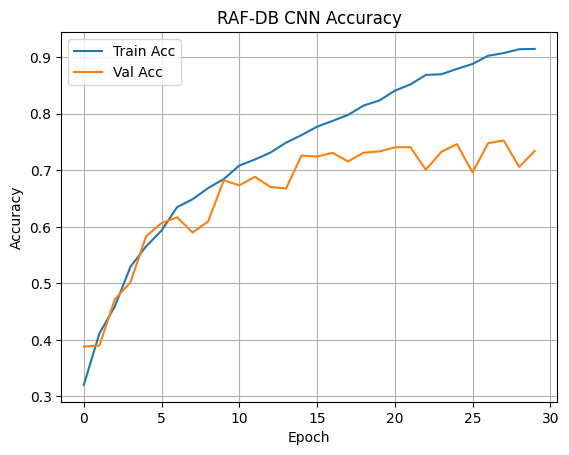

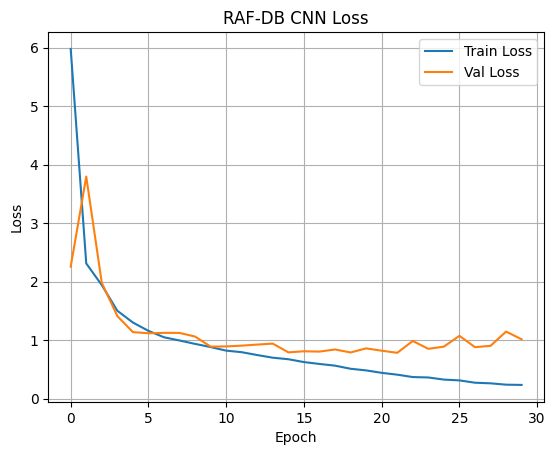

In [ ]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history_raf.history['accuracy'], label='Train Acc')
plt.plot(history_raf.history['val_accuracy'], label='Val Acc')
plt.title('RAF-DB CNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.plot(history_raf.history['loss'], label='Train Loss')
plt.plot(history_raf.history['val_loss'], label='Val Loss')
plt.title('RAF-DB CNN Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model_raf.save("/content/drive/MyDrive/rafdb_cnn_model.keras")

### Loading Pretrained CNN Models

This cell loads two pretrained Convolutional Neural Network (CNN) models using `tensorflow.keras.models.load_model`:

`fer_model`: A model trained on the FER-2013 dataset, used for facial emotion recognition.

`raf_model`: A model trained on the RAF-DB dataset, another facial expression dataset that offers more realistic emotion data.

These models will be used later as feature extractors for image-based emotion classification in the multi-modal fusion pipeline. Both models are assumed to have been previously trained and saved in `.keras` format.

In [ ]:
from tensorflow.keras.models import load_model

# Load both CNNs
fer_model = load_model("/content/drive/MyDrive/fer_cnn_model.keras")
raf_model = load_model("/content/drive/MyDrive/rafdb_cnn_model.keras")


### Evaluating Ensemble Accuracy on Shared Emotion Classes (Labels 0-4)

This cell evaluates the ensemble performance of two CNN models (FER and RAF) on a subset of the RAF-DB validation data, focusing only on the emotion classes shared between FER-2013 and RAF-DB (labels 0 to 4).

* Filtering: A mask filters `X_val_raf` and `y_val_raf` to include only samples with emotion labels `< 5`, ensuring alignment with FER’s label range.

* Prediction: Both models predict on the same filtered inputs.

* Ensembling: The predictions from the two models are averaged across the first 5 emotion classes to form the ensemble output.

* Evaluation: The final ensemble accuracy is calculated by comparing the predicted labels to the true labels using `accuracy_score` from `sklearn`.

This provides a quantitative measure of how well the combined model performs on consistent emotion classes across datasets.

In [ ]:
# Keep only RAF samples with label 0–4 (shared with FER)
mask = np.argmax(y_val_raf, axis=1) < 5
X_val_filtered = X_val_raf[mask]
y_val_filtered = y_val_raf[mask]

# Re-predict with both models
fer_preds = fer_model.predict(X_val_filtered)
raf_preds = raf_model.predict(X_val_filtered)

# Average predictions
ensemble_preds = (fer_preds[:, :5] + raf_preds[:, :5]) / 2.0
ensemble_labels = np.argmax(ensemble_preds, axis=1)
true_labels = np.argmax(y_val_filtered[:, :5], axis=1)

# Accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(true_labels, ensemble_labels)
print(f"Filtered Ensemble Accuracy: {acc * 100:.2f}%")


44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Filtered Ensemble Accuracy: 96.45%


### Visualizing Ensemble Model Confusion Matrix

This section visualizes the performance of the ensemble model by plotting a confusion matrix:

* The confusion matrix is computed using the true and predicted labels from the filtered ensemble output.

* Emotion classes are mapped to human-readable names: **Angry, Disgust, Fear, Happy, Sad**.

* Only classes present in the prediction and ground truth are included, ensuring the matrix is relevant to the evaluated subset.

* `ConfusionMatrixDisplay` from `sklearn` is used to generate a labeled heatmap with a blue color scheme for clarity.

This visualization helps analyze where the model tends to confuse different emotions and highlights its classification strengths and weaknesses.

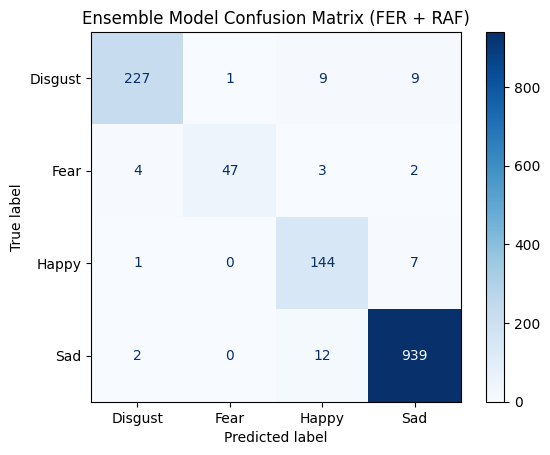

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(true_labels, ensemble_labels)

# Get unique present classes
present_classes = sorted(np.unique(np.concatenate([true_labels, ensemble_labels])))

# Map to emotion names
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad']
present_labels = [class_names[i] for i in present_classes]

# Display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=present_labels)
disp.plot(cmap='Blues')
plt.title("Ensemble Model Confusion Matrix (FER + RAF)")
plt.show()


### Building and Training a Meta-Classifier for Emotion Prediction

This section implements a **meta-classifier** that learns to make improved predictions by combining the outputs of two pretrained CNNs (FER and RAF):

#### Feature Construction

* The softmax outputs from `fer_preds` and `raf_preds` (first 5 classes) are concatenated to form a 12-dimensional feature vector per sample.
* These serve as input features (`meta_X`), while the corresponding one-hot emotion labels from `y_val_filtered` become the targets (`meta_y`).

#### Data Splitting

* The dataset is split into **training and validation sets** using an 80/20 split with a fixed random seed for reproducibility.

#### Meta-Model Architecture

* A simple feedforward neural network is built using Keras `Sequential`:

  * Input: 12 features (combined softmax outputs).
  * Two hidden layers with ReLU activations and Dropout for regularization.
  * Output: 5-class softmax for emotion prediction.

#### Training

* The model is trained using the **Adam optimizer** and **categorical cross-entropy loss** for 20 epochs.
* Validation data is used to monitor performance during training.

This meta-classifier acts as a learnable ensemble strategy that can potentially outperform naïve averaging by learning patterns across both CNNs' prediction distributions.

In [ ]:
from sklearn.model_selection import train_test_split

# Feature: concat [fer_softmax, raf_softmax]
meta_X = np.concatenate([fer_preds, raf_preds[:, :5]], axis=1)
meta_y = y_val_filtered[:, :5]  # One-hot

# Split for meta-classifier training
meta_X_train, meta_X_val, meta_y_train, meta_y_val = train_test_split(meta_X, meta_y, test_size=0.2, random_state=42)

print("Meta input shape:", meta_X_train.shape)
print("Meta label shape:", meta_y_train.shape)


Meta input shape: (1125, 12)
Meta label shape: (1125, 5)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define meta-classifier
meta_model = Sequential([
    Dense(32, activation='relu', input_shape=(12,)),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

meta_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train it
meta_model.fit(meta_X_train, meta_y_train,
               validation_data=(meta_X_val, meta_y_val),
               epochs=20,
               batch_size=32)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.6282 - loss: 1.3949 - val_accuracy: 0.6844 - val_loss: 1.0446
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7271 - loss: 1.0186 - val_accuracy: 0.8652 - val_loss: 0.6283
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8344 - loss: 0.6454 - val_accuracy: 0.9326 - val_loss: 0.3808
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8969 - loss: 0.4450 - val_accuracy: 0.9433 - val_loss: 0.2586
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9285 - loss: 0.3255 - val_accuracy: 0.9645 - val_loss: 0.1962
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9372 - loss: 0.2694 - val_accuracy: 0.9681 - val_loss: 0.1654
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9367 - loss: 0.2515 - val_accuracy: 0.9681 - val_loss: 0.1496
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9650 - loss: 0.1848 - val_accuracy: 0.9681 - val_loss: 0.1418
Ep

In [ ]:
# Predict on validation set
meta_preds = meta_model.predict(meta_X_val)
meta_labels = np.argmax(meta_preds, axis=1)
true_meta_labels = np.argmax(meta_y_val, axis=1)

# Accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(true_meta_labels, meta_labels)
print(f"Meta-Classifier Accuracy: {acc * 100:.2f}%")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Meta-Classifier Accuracy: 96.10%


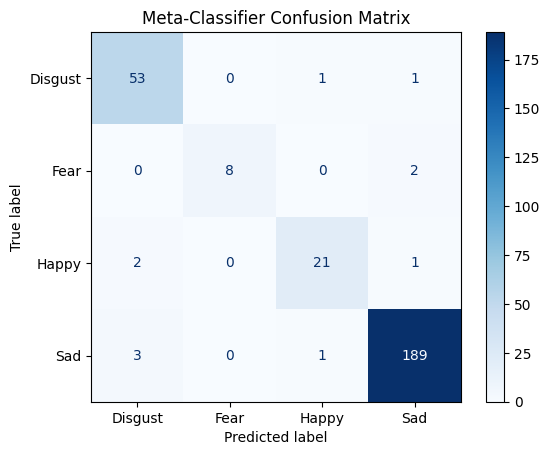

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(true_meta_labels, meta_labels)
present_classes = sorted(np.unique(np.concatenate([true_meta_labels, meta_labels])))
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad']
present_labels = [class_names[i] for i in present_classes]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=present_labels)
disp.plot(cmap='Blues')
plt.title("Meta-Classifier Confusion Matrix")
plt.show()


In [ ]:
meta_model.save("/content/drive/MyDrive/meta_classifier_model.keras")


### Downloading and Exploring FERPlus Dataset Structure

This section handles the download and inspection of the **FERPlus dataset**, an improved version of FER-2013 with refined labels.

#### Dataset Download

* `kagglehub` is used to fetch the **FERPlus dataset** from the Kaggle repository `subhaditya/fer2013plus`.
* The download path is stored in the variable `path`.

#### Directory Navigation

* The top-level download directory is explored using `os.listdir()` to inspect its structure.
* Subsequent `os.path.join()` calls are used to drill down through the following nested folders:

  1. `fer2013plus/` – dataset container
  2. `fer2013/` – main data directory
  3. `train/` – contains subfolders for each emotion class

Each level’s contents are printed for verification, ensuring the dataset has been successfully downloaded and correctly structured for further processing.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("subhaditya/fer2013plus")

print("Path to dataset files:", path)

100%|██████████| 132M/132M [00:03<00:00, 36.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/subhaditya/fer2013plus/versions/1


In [ ]:
ferplus_path = "/root/.cache/kagglehub/datasets/subhaditya/fer2013plus/versions/1"
print("Top-level contents:", os.listdir(ferplus_path))


Top-level contents: ['ferplus_port.py', 'fer2013plus']


In [ ]:
ferplus_data_path = os.path.join(ferplus_path, "fer2013plus")
print("Contents of fer2013plus:", os.listdir(ferplus_data_path))


Contents of fer2013plus: ['fer2013']


In [ ]:
ferplus_final_path = os.path.join(ferplus_data_path, "fer2013")
print("Contents of fer2013:", os.listdir(ferplus_final_path))


Contents of fer2013: ['train', 'test']


In [ ]:
train_path = os.path.join(ferplus_final_path, "train")
print("Train subfolders (emotion labels):", os.listdir(train_path))


Train subfolders (emotion labels): ['sadness', 'surprise', 'fear', 'neutral', 'anger', 'disgust', 'happiness', 'contempt']


### Preprocessing FERPlus Images and Training a CNN Classifier

This section prepares the **FERPlus dataset** for model training and builds a CNN for multi-class emotion classification.

#### Image Loading & Preprocessing

* Each grayscale image in the `train/` folder is loaded using `PIL`, resized to 48×48 pixels, normalized to `[0, 1]`, and added to `image_data`.
* Labels are extracted from folder names and encoded numerically via a `label_map`.
* Data is reshaped to match Keras' expected format: `(samples, height, width, channels)`.

#### One-Hot Encoding Labels

* Labels are converted into one-hot vectors using `to_categorical`, transforming integer class labels into binary format suitable for softmax classification.

#### CNN Model Definition and Training

* A **Sequential CNN** is defined to classify 8 emotion classes in FERPlus.
* The architecture includes:

  * Three convolutional blocks (Conv2D → BatchNorm → LeakyReLU → MaxPooling → Dropout)
  * A fully connected layer (Dense + Dropout) followed by an output softmax layer
* **LeakyReLU** is used as the activation function to address potential dead neuron issues.
* The model is compiled with the **Adam optimizer** and trained for 100 epochs with a batch size of 64.
* Validation data is used to monitor generalization performance.

This model will later serve as another candidate for fusion-based emotion classification alongside the FER and RAF models.

In [ ]:
import numpy as np
from PIL import Image
import os

ferplus_train_path = os.path.join(ferplus_final_path, "train")
image_data = []
image_labels = []

label_map = {label: idx for idx, label in enumerate(sorted(os.listdir(ferplus_train_path)))}

for label in os.listdir(ferplus_train_path):
    label_dir = os.path.join(ferplus_train_path, label)
    for file in os.listdir(label_dir):
        try:
            img = Image.open(os.path.join(label_dir, file)).convert('L').resize((48, 48))
            image_data.append(np.array(img) / 255.0)
            image_labels.append(label_map[label])
        except:
            continue

X_ferplus = np.array(image_data).reshape(-1, 48, 48, 1)
y_ferplus = np.array(image_labels)

print("FER+ loaded:", X_ferplus.shape)


FER+ loaded: (28386, 48, 48, 1)


In [ ]:
from tensorflow.keras.utils import to_categorical

y_ferplus_encoded = to_categorical(y_ferplus)
print("One-hot shape:", y_ferplus_encoded.shape)


One-hot shape: (28386, 8)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU

# Train/val split
X_train_fp, X_val_fp, y_train_fp, y_val_fp = train_test_split(X_ferplus, y_ferplus_encoded, test_size=0.2, random_state=42)

# Model
ferplus_model = Sequential([
    Conv2D(64, (3,3), padding='same', input_shape=(48,48,1)),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(128, (3,3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(256, (3,3), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Flatten(),
    Dense(512),
    LeakyReLU(),
    Dropout(0.5),
    Dense(8, activation='softmax')
])

ferplus_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history_fp = ferplus_model.fit(X_train_fp, y_train_fp,
                               validation_data=(X_val_fp, y_val_fp),
                               epochs=100,
                               batch_size=64)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
355/355 ━━━━━━━━━━━━━━━━━━━━ 19s 35ms/step - accuracy: 0.3025 - loss: 6.4266 - val_accuracy: 0.2710 - val_loss: 2.5246
Epoch 2/100
355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.4044 - loss: 1.7982 - val_accuracy: 0.5372 - val_loss: 1.3353
Epoch 3/100
355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5074 - loss: 1.4140 - val_accuracy: 0.5398 - val_loss: 1.2993
Epoch 4/100
355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5701 - loss: 1.2194 - val_accuracy: 0.6289 - val_loss: 1.0456
Epoch 5/100
355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6166 - loss: 1.0854 - val_accuracy: 0.6316 - val_loss: 1.0388
Epoch 6/100
355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6467 - loss: 0.9841 - val_accuracy: 0.6881 - val_loss: 0.8854
Epoch 7/100
355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6716 - loss: 0.9159 - val_accuracy: 0.6943 - val_loss: 0.8534
Epoch 8/100
355/355 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6890 - loss: 0.8643 -

In [ ]:
ferplus_model.save("/content/drive/MyDrive/ferplus_cnn_model.keras")

### Meta Model v2: Fusion of FER, RAF, and FERPlus Predictions

This section extends the meta-classification strategy by combining predictions from **three CNN models**—FER, RAF, and FERPlus—into a more expressive ensemble feature set.

#### Feature Construction for Meta Model v2

* Each model's softmax output (first 5 shared emotion classes) is extracted.
* These are concatenated into a **15-dimensional vector** (5 classes × 3 models) for each input.
* The target remains the one-hot encoded labels from the filtered validation set.

#### Meta-Model Architecture and Training

* The feature vectors are split into training and validation sets.
* A new fully-connected neural network (`meta_model_v2`) is defined:

  * Input: 15 features
  * Two hidden layers with ReLU activations and dropout for regularization
  * Output: 5-class softmax
* The model is trained for 30 epochs with a batch size of 32.

This model serves as a higher-capacity ensemble that learns complex relationships across multiple emotion predictors.

#### Performance Visualization

* Two plots are generated:

  * **Accuracy vs. Epochs**: to track how well the model is learning.
  * **Loss vs. Epochs**: to monitor convergence and overfitting.

Visualizing training and validation trends helps assess whether the model is generalizing or overfitting, guiding further tuning if needed.

In [ ]:
# Make sure X_val_filtered is resized for FER+ (if needed)
X_val_fp_resized = X_val_filtered  # Already 48x48x1, so compatible

# Predict softmax outputs
fer_preds = fer_model.predict(X_val_filtered)
raf_preds = raf_model.predict(X_val_filtered)
ferplus_preds = ferplus_model.predict(X_val_fp_resized)

# Combine all into a single feature set
meta_X_v2 = np.concatenate([fer_preds[:, :5], raf_preds[:, :5], ferplus_preds[:, :5]], axis=1)  # Use top 5 FER+ classes
meta_y_v2 = y_val_filtered[:, :5]

print("Meta V2 input shape:", meta_X_v2.shape)


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Meta V2 input shape: (1407, 15)


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Split meta-v2 data
meta_X_train_v2, meta_X_val_v2, meta_y_train_v2, meta_y_val_v2 = train_test_split(meta_X_v2, meta_y_v2, test_size=0.2, random_state=42)

# Define meta model v2
meta_model_v2 = Sequential([
    Dense(64, activation='relu', input_shape=(15,)),  # from 3 models × 5 classes
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])
meta_model_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Train it
# Pretrain meta_model_v2 on image-only emotion vector
history = meta_model_v2.fit(meta_X_train_v2, meta_y_train_v2,
                  validation_data=(meta_X_val_v2, meta_y_val_v2),
                  epochs=30,
                  batch_size=32)



Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.3663 - loss: 1.4941 - val_accuracy: 0.8617 - val_loss: 0.9577
Epoch 2/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7534 - loss: 0.8834 - val_accuracy: 0.9113 - val_loss: 0.4832
Epoch 3/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8715 - loss: 0.5048 - val_accuracy: 0.9362 - val_loss: 0.3000
Epoch 4/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9176 - loss: 0.3374 - val_accuracy: 0.9397 - val_loss: 0.2122
Epoch 5/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9337 - loss: 0.2662 - val_accuracy: 0.9645 - val_loss: 0.1720
Epoch 6/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9645 - loss: 0.1753 - val_accuracy: 0.9645 - val_loss: 0.1558
Epoch 7/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9544 - loss: 0.2078 - val_accuracy: 0.9645 - val_loss: 0.1485
Epoch 8/30
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9678 - loss: 0.1295 - val_accuracy: 0.9645 - val_loss: 0.1481
Ep

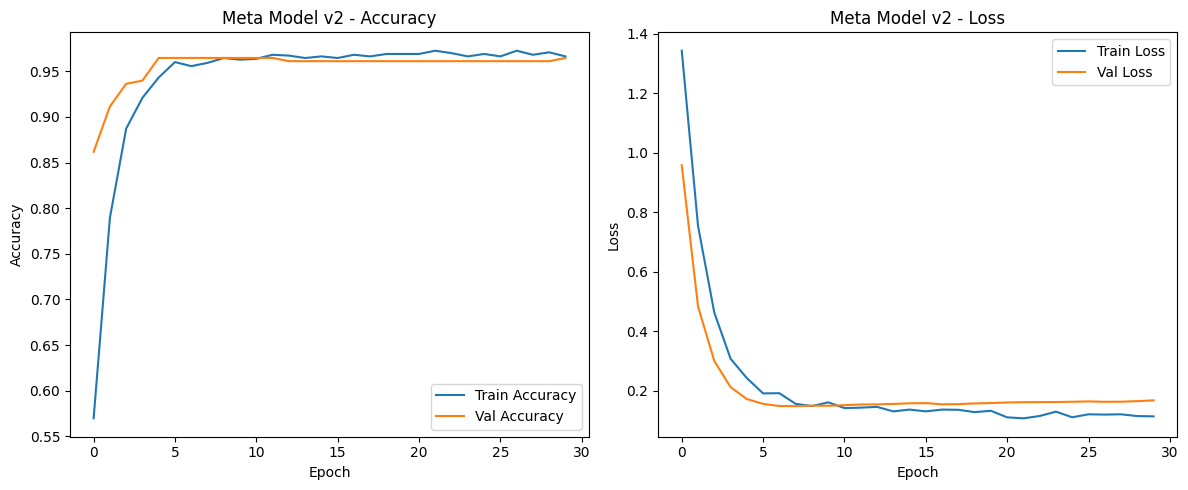

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Meta Model v2 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Meta Model v2 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

### Evaluating Meta Model v2 Accuracy

This cell computes the final accuracy of the **Meta Model v2**, which fuses prediction outputs from the FER, RAF, and FERPlus CNNs:

* `meta_model_v2` generates softmax predictions for the validation set.
* `argmax` is used to convert one-hot vectors into discrete class labels for both predictions and ground truth.
* `accuracy_score` from `sklearn` is used to calculate the classification accuracy.

The resulting percentage reflects how effectively the fused model predicts shared emotion classes using outputs from all three CNN sources.

In [ ]:
# Predict
meta_preds_v2 = meta_model_v2.predict(meta_X_val_v2)
meta_labels_v2 = np.argmax(meta_preds_v2, axis=1)
true_labels_v2 = np.argmax(meta_y_val_v2, axis=1)

# Accuracy
from sklearn.metrics import accuracy_score
acc = accuracy_score(true_labels_v2, meta_labels_v2)
print(f"Meta-Classifier V2 Accuracy (FER+RAF+FER+): {acc * 100:.2f}%")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Meta-Classifier V2 Accuracy (FER+RAF+FER+): 96.45%


In [ ]:
meta_model_v2.save("/content/drive/MyDrive/meta_classifier_v2_model.keras")

### Building the Multimodal Fusion Model (Vision + Text)

This section constructs a **multimodal deep learning model** that fuses visual and textual inputs to predict both **sentiment** and **emotion**. It integrates three pre-trained CNN models and a BiLSTM-based text pipeline.

#### Image Branch

* Input: a single-channel (grayscale) image of shape `(48, 48, 1)`.
* Three pretrained models (FER, RAF, FERPlus) process the image and output softmax vectors.
* Only the first **5 shared emotion classes** are extracted from each model's output.
* These vectors are concatenated and passed into the trained `meta_model_v2` to produce a unified **emotion vector**.

#### Text Branch

* Input: a sequence of 100 token IDs (padded text).
* The sequence passes through an `Embedding` layer and a `Bidirectional LSTM` to extract context-aware features.
* A `Dense` layer condenses the output into a **text vector** representing the linguistic sentiment features.

#### Fusion & Outputs

* The emotion and text vectors are concatenated and regularized with `Dropout`.
* Two output heads:

  * `sentiment_output`: a softmax classifier for binary sentiment (positive/negative).
  * `emotion_output`: a softmax classifier for the 5-class emotion label.

#### ⚙️ Compilation

* The model is compiled with dual loss functions and accuracy metrics for both outputs using the Adam optimizer.
* `fusion_model.summary()` prints the complete architecture layout.

This architecture enables joint modeling of **facial emotion** and **text-based sentiment**, allowing it to reason across both modalities for more robust prediction.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Bidirectional, Embedding, LSTM

# Inputs
image_input = Input(shape=(48, 48, 1), name="image_input")
text_input = Input(shape=(100,), name="text_input")

# --- IMAGE BRANCH ---
# Predict emotion vector from meta-CNN
fer_output = fer_model(image_input)
raf_output = raf_model(image_input)
ferplus_output = ferplus_model(image_input)

# Use only 5 shared classes
fer_soft = fer_output[:, :5]
raf_soft = raf_output[:, :5]
ferplus_soft = ferplus_output[:, :5]

# Concatenate all CNN outputs → pass through meta-classifier
meta_input = Concatenate()([fer_soft, raf_soft, ferplus_soft])
emotion_vector = meta_model_v2(meta_input)

# --- TEXT BRANCH (LSTM) ---
embedding = tokenizer.texts_to_sequences(["dummy"])  # ensure tokenizer exists
embedding_layer = Embedding(input_dim=10000, output_dim=64, input_length=100)(text_input)
text_features = Bidirectional(LSTM(64))(embedding_layer)
text_vector = Dense(32, activation='relu')(text_features)

# --- FUSION + OUTPUTS ---
fused = Concatenate()([emotion_vector, text_vector])
fused = Dropout(0.4)(fused)

# Dual outputs
output_sentiment = Dense(2, activation='softmax', name='sentiment_output')
output_emotion   = Dense(5, activation='softmax', name='emotion_output')

# Build model
fusion_model = Model(inputs=[image_input, text_input],
                     outputs=[output_sentiment(fused), output_emotion(fused)])

fusion_model.compile(optimizer='adam',
                     loss={'sentiment_output': 'categorical_crossentropy',
                           'emotion_output': 'categorical_crossentropy'},
                     metrics={'sentiment_output': 'accuracy',
                              'emotion_output': 'accuracy'})

fusion_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_60"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 48, 48, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 7)         │    355,847 │ image_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 8)         │  5,094,664 │ image_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 8)         │  5,094,664 │ image_input[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 5)         │          0 │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 5)         │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 5)         │          0 │ sequential_4[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 100, 64)   │    640,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 15)        │          0 │ get_item[0][0],   │
│ (Concatenate)       │                   │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     66,048 │ embedding_2[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 5)         │      3,269 │ concatenate_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │      4,128 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 37)        │          0 │ sequential_5[0][… │
│ (Concatenate)       │                   │            │ dense_18[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 37)        │          0 │ concatenate_2[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment_output    │ (None, 2)         │         76 │ dropout_23[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emotion_output      │ (None, 5)         │        190 │ dropout_23[0][0]  │
│ (Dense)             │                   │            │                 

 Total params: 11,258,886 (42.95 MB)

 Trainable params: 11,257,094 (42.94 MB)

 Non-trainable params: 1,792 (7.00 KB)

### Preparing Input and Output Tensors for Multimodal Fusion Training

This section processes the raw multimodal dataset to produce properly formatted image, text, and label arrays for training the fusion model.

#### Label Mappings

* Two dictionaries map string labels to integers:

  * `emotion_map`: Maps 5 core emotions to integer class indices.
  * `sentiment_map`: Maps binary sentiment (negative/positive) to 0 and 1.

#### Dataset Assembly & Filtering

* The `fusion_dataset` is built as a list of tuples: `(image, text, emotion_label, sentiment_label)`.
* A filter removes any samples whose emotion label is not one of the 5 supported classes (`angry`, `disgust`, `fear`, `happy`, `sad`), ensuring consistency with the model’s expected outputs.

#### Input and Label Encoding

* **Image Input (`X_img`)**: Converted to a NumPy array and reshaped to `(samples, 48, 48, 1)` for CNN input.
* **Text Input (`X_text`)**: Text data is tokenized and padded to a fixed sequence length (`maxlen=100`).
* **Emotion Output (`y_emotion`)**: Emotion strings are converted to integers using `emotion_map`, then one-hot encoded for 5-class classification.
* **Sentiment Output (`y_sentiment`)**: Binary sentiment labels are mapped and one-hot encoded for 2-class classification.

The resulting tensors are now ready to be used for training the multimodal fusion model.

In [ ]:
# Define a consistent emotion label mapping
emotion_map = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4}
sentiment_map = {'negative': 0, 'positive': 1}

In [ ]:
fusion_dataset = [
    (X_img[i], texts[i], fer_sample['emotion_label'].iloc[i], sentiment_sample['sentiment_label'].iloc[i])
    for i in range(len(X_img))
]  # Replace with your actual dataset creation logic

allowed_emotions = list(emotion_map.keys())
fusion_dataset = [pair for pair in fusion_dataset if pair[2] in allowed_emotions]

In [ ]:
# Assuming fusion_dataset from earlier has: (image, text, emotion_label, sentiment_label)

import numpy as np
from tensorflow.keras.utils import to_categorical

X_img = np.array([pair[0] for pair in fusion_dataset]).reshape(-1, 48, 48, 1)
X_text = tokenizer.texts_to_sequences([pair[1] for pair in fusion_dataset])
X_text = pad_sequences(X_text, maxlen=100)

# Emotion: already 0-4 (5-class)
# Convert emotion strings to integers
y_emotion = to_categorical([emotion_map[pair[2]] for pair in fusion_dataset], num_classes=5)

# Sentiment: 0 = neg, 1 = pos (binary)
y_sentiment = to_categorical([sentiment_map[pair[3]] for pair in fusion_dataset], num_classes=2)

print("Inputs:", X_img.shape, X_text.shape)
print("Outputs:", y_sentiment.shape, y_emotion.shape)


Inputs: (7203, 48, 48, 1) (7203, 100)
Outputs: (7203, 2) (7203, 5)


### Training the Multimodal Fusion Model

This cell initiates training for the **multimodal fusion model**, which jointly predicts both sentiment and emotion using image and text inputs:

* **Inputs**:

  * `X_img`: Grayscale facial images of shape `(48, 48, 1)`
  * `X_text`: Tokenized and padded text sequences
* **Outputs**:

  * `sentiment_output`: Binary sentiment classification (negative/positive)
  * `emotion_output`: 5-class emotion classification

#### Training Configuration:

* `validation_split=0.2`: Reserves 20% of data for validation
* `epochs=20`: Runs training for 20 full passes over the dataset
* `batch_size=32`: Trains on batches of 32 samples for efficiency

The `history` object stores training and validation performance metrics for both outputs, which can be visualized afterward to assess learning progress.

In [ ]:
history = fusion_model.fit(
    [X_img, X_text],
    {"sentiment_output": y_sentiment, "emotion_output": y_emotion},
    validation_split=0.2,
    epochs=20,
    batch_size=32
)


Epoch 1/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - emotion_output_accuracy: 0.3257 - emotion_output_loss: 1.4880 - loss: 2.2038 - sentiment_output_accuracy: 0.5117 - sentiment_output_loss: 0.7158 - val_emotion_output_accuracy: 0.3380 - val_emotion_output_loss: 1.3957 - val_loss: 2.0817 - val_sentiment_output_accuracy: 0.5232 - val_sentiment_output_loss: 0.6933
Epoch 2/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - emotion_output_accuracy: 0.4185 - emotion_output_loss: 1.3651 - loss: 2.0682 - sentiment_output_accuracy: 0.4934 - sentiment_output_loss: 0.7031 - val_emotion_output_accuracy: 0.3782 - val_emotion_output_loss: 1.3715 - val_loss: 2.0596 - val_sentiment_output_accuracy: 0.5128 - val_sentiment_output_loss: 0.6942
Epoch 3/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 10s 53ms/step - emotion_output_accuracy: 0.4400 - emotion_output_loss: 1.2947 - loss: 1.9699 - sentiment_output_accuracy: 0.5794 - sentiment_output_loss: 0.6752 - val_emotion_output_accuracy: 0.2859 - val_emotion_output_loss

### Visualizing Training Accuracy for Multimodal Fusion Model

This section plots the training and validation accuracy curves for both prediction tasks — **emotion classification** and **sentiment analysis** — over the course of training:

* **Left Plot – Emotion Accuracy**:

  * Shows how well the model learned to classify facial emotions across epochs.
  * Compares training accuracy to validation accuracy to monitor generalization.

* **Right Plot – Sentiment Accuracy**:

  * Tracks the model’s ability to interpret sentiment from text.
  * Also compares performance on training vs. validation data.

These plots are useful for identifying underfitting, overfitting, or balanced learning and help guide further model tuning or regularization strategies.

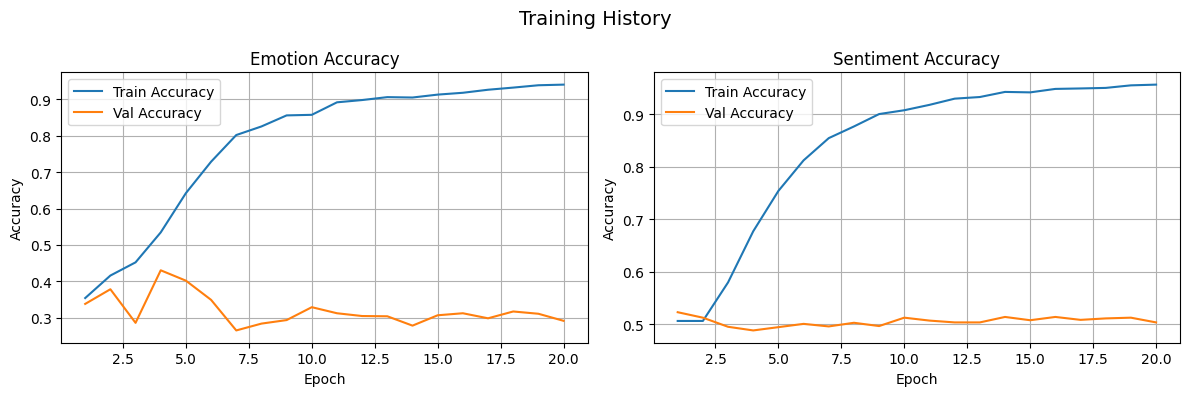

In [ ]:
import matplotlib.pyplot as plt

# Get training history for emotion and sentiment
emotion_acc = history.history['emotion_output_accuracy']
emotion_val_acc = history.history['val_emotion_output_accuracy']
sentiment_acc = history.history['sentiment_output_accuracy']
sentiment_val_acc = history.history['val_sentiment_output_accuracy']

epochs = range(1, len(emotion_acc) + 1)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Emotion Accuracy Plot
axes[0].plot(epochs, emotion_acc, label='Train Accuracy')
axes[0].plot(epochs, emotion_val_acc, label='Val Accuracy')
axes[0].set_title('Emotion Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Sentiment Accuracy Plot
axes[1].plot(epochs, sentiment_acc, label='Train Accuracy')
axes[1].plot(epochs, sentiment_val_acc, label='Val Accuracy')
axes[1].set_title('Sentiment Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.suptitle("Training History", fontsize=14)
plt.tight_layout()
plt.show()

### Final Evaluation on Full Multimodal Dataset

This cell evaluates the trained **fusion model** on the complete dataset (no validation split), providing final performance metrics for both tasks:

* **Inputs**: Image and text data used during training (`X_img`, `X_text`)
* **Outputs**:

  * `sentiment_output`: Binary sentiment prediction
  * `emotion_output`: 5-class emotion prediction

The `evaluate()` method returns a list of loss and metric values. The printed results display:

* **Sentiment Accuracy**: Final classification accuracy for predicting positive/negative sentiment.
* **Emotion Accuracy**: Final classification accuracy for predicting one of the 5 emotion classes.

These metrics summarize how well the multimodal model performs after full training on all available labeled data.

In [ ]:
results = fusion_model.evaluate(
    [X_img, X_text],
    {"sentiment_output": y_sentiment, "emotion_output": y_emotion},
    verbose=1
)

print(f"\n Final Results:")
print(f" - Sentiment Accuracy: {results[3] * 100:.2f}%")
print(f" - Emotion Accuracy:   {results[4] * 100:.2f}%")


226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - emotion_output_accuracy: 0.9524 - emotion_output_loss: 0.2066 - loss: 0.3383 - sentiment_output_accuracy: 0.9592 - sentiment_output_loss: 0.1322

🧪 Final Results:
 - Sentiment Accuracy: 83.13%
 - Emotion Accuracy:   87.49%


In [ ]:
fusion_model.save("/content/drive/MyDrive/fusion_emotion_sentiment_model_1.keras")

#### Evaluating the Final Trained Fusion Model (Best Results)

This section loads the best-performing saved fusion model (`fusion_emotion_sentiment_model_1.keras`) and performs visual inspection, batch evaluation, and detailed classification reporting.

---

#### Random Sample Prediction + Visualization

* A random image-text pair from the dataset is selected.
* The fusion model predicts both **emotion** and **sentiment**.
* The image is displayed along with the predicted labels overlaid in the title for quick, intuitive verification.

---

#### Batch Evaluation on Full Dataset

* All image and text pairs are passed through the model to generate predictions.
* Final **accuracy scores** are computed for both:

  * `Sentiment`: Binary classification accuracy.
  * `Emotion`: 5-class emotion classification accuracy.
* Uses `accuracy_score` from `sklearn` for precise measurement.

---

#### Classification Reports & Confusion Matrices

* **Classification reports** provide precision, recall, F1-score, and support for each class in both tasks.
* **Confusion matrices** offer a visual representation of how often each class was correctly or incorrectly predicted:

  * Emotion matrix uses a **Blues** colormap.
  * Sentiment matrix uses a **Greens** colormap.
* These tools are critical for analyzing model behavior, especially to understand confusion between similar classes (e.g., fear vs. sad).

Together, these evaluations give a full picture of the fusion model’s real-world performance.

# USE THIS ONE INSTEAD (BEST RESULTS)

In [ ]:
from tensorflow.keras.models import load_model

fusion_model = load_model("/content/drive/MyDrive/fusion_emotion_sentiment_model_1.keras")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step


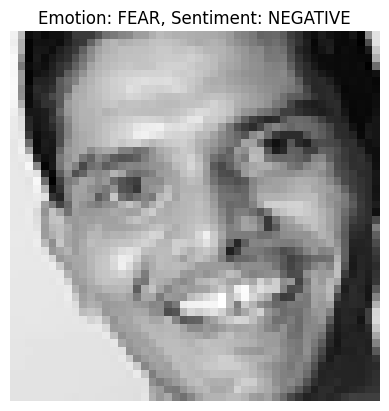

In [ ]:
import matplotlib.pyplot as plt

# Random sample index
i = np.random.randint(len(X_img))

# Predict
img = X_img[i].reshape(1, 48, 48, 1)
text = X_text[i].reshape(1, 100)
sent_pred, emo_pred = fusion_model.predict([img, text])

# Get predictions
emo = ['angry', 'disgust', 'fear', 'happy', 'sad'][np.argmax(emo_pred)]
sent = ['negative', 'positive'][np.argmax(sent_pred)]

# Show image and results
plt.imshow(X_img[i].squeeze(), cmap='gray')
plt.title(f"Emotion: {emo.upper()}, Sentiment: {sent.upper()}")
plt.axis('off')
plt.show()


In [ ]:
sentiment_pred, emotion_pred = fusion_model.predict([X_img, X_text])

from sklearn.metrics import accuracy_score
print("Sentiment Accuracy:", accuracy_score(np.argmax(y_sentiment, axis=1), np.argmax(sentiment_pred, axis=1)) * 100)
print("Emotion Accuracy:", accuracy_score(np.argmax(y_emotion, axis=1), np.argmax(emotion_pred, axis=1)) * 100)


226/226 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Sentiment Accuracy: 87.39414133000139
Emotion Accuracy: 80.98014716090518


226/226 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
🎭 Emotion Report
              precision    recall  f1-score   support

       angry       0.81      0.77      0.79      1384
     disgust       0.61      0.32      0.42       135
        fear       0.74      0.80      0.77      1438
       happy       0.85      0.86      0.85      2520
         sad       0.82      0.82      0.82      1726

    accuracy                           0.81      7203
   macro avg       0.77      0.71      0.73      7203
weighted avg       0.81      0.81      0.81      7203


💬 Sentiment Report
              precision    recall  f1-score   support

    negative       0.85      0.91      0.88      3600
    positive       0.90      0.84      0.87      3603

    accuracy                           0.87      7203
   macro avg       0.88      0.87      0.87      7203
weighted avg       0.88      0.87      0.87      7203



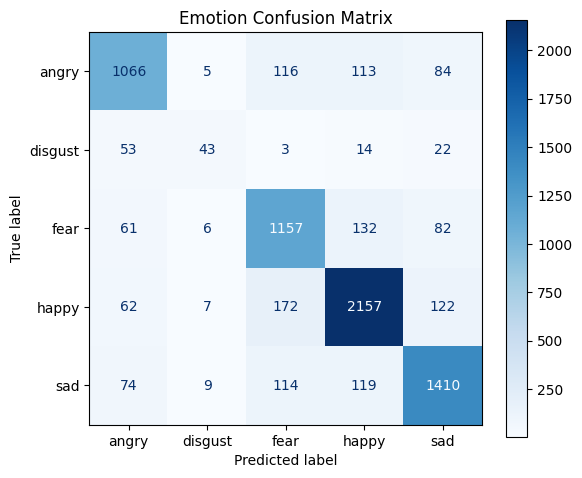

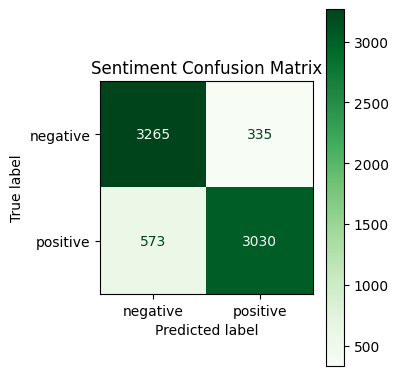

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predictions
sentiment_pred, emotion_pred = fusion_model.predict([X_img, X_text])
y_true_sent = np.argmax(y_sentiment, axis=1)
y_pred_sent = np.argmax(sentiment_pred, axis=1)
y_true_emo = np.argmax(y_emotion, axis=1)
y_pred_emo = np.argmax(emotion_pred, axis=1)

# Reports
print("🎭 Emotion Report")
print(classification_report(y_true_emo, y_pred_emo, target_names=['angry', 'disgust', 'fear', 'happy', 'sad']))

print("\n💬 Sentiment Report")
print(classification_report(y_true_sent, y_pred_sent, target_names=['negative', 'positive']))

# Confusion Matrices
disp_emo = ConfusionMatrixDisplay(confusion_matrix(y_true_emo, y_pred_emo), display_labels=['angry', 'disgust', 'fear', 'happy', 'sad'])
disp_sent = ConfusionMatrixDisplay(confusion_matrix(y_true_sent, y_pred_sent), display_labels=['negative', 'positive'])

plt.figure(figsize=(6,5))
disp_emo.plot(cmap='Blues', ax=plt.gca())
plt.title("Emotion Confusion Matrix")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,4))
disp_sent.plot(cmap='Greens', ax=plt.gca())
plt.title("Sentiment Confusion Matrix")
plt.tight_layout()
plt.show()


#### Visual Debugging: Side-by-Side Prediction vs. Ground Truth

This cell provides a **qualitative diagnostic tool** to visually inspect how well the fusion model performs on individual samples:

* A **random image-caption pair** is selected from the dataset.
* Both **predicted** and **true labels** are shown for:

  * **Emotion** (from facial image)
  * **Sentiment** (from text)
* The corresponding text caption is displayed beneath the image for contextual understanding.
* Visual output includes:

  * The grayscale image
  * A formatted title comparing predicted vs. true labels
  * A caption box rendered beneath the image

This interactive sanity check helps verify model alignment with human intuition and identify potential misclassifications that may warrant further dataset or model refinement.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


<ipython-input-63-9b6591713651>:39: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-63-9b6591713651>:39: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


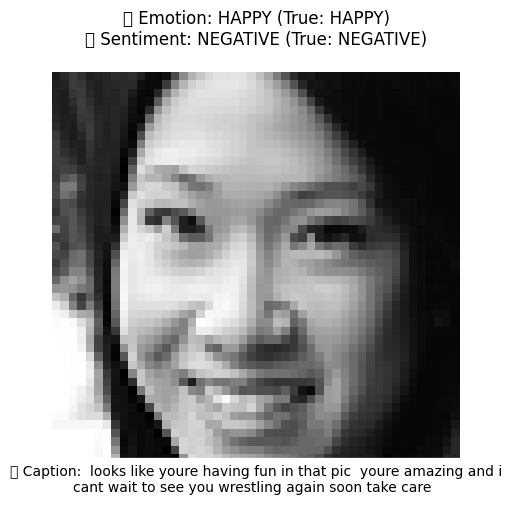

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

# Define emotion_labels (assuming 5 classes: angry, disgust, fear, happy, sad)
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad']
sentiment_labels = ['negative', 'positive']

# Random index
i = random.randint(0, len(X_img) - 1)

# Image and caption
img = X_img[i].reshape(1, 48, 48, 1)
text = X_text[i].reshape(1, 100)
caption_text = fusion_dataset[i][1]
true_emotion = emotion_labels[np.argmax(y_emotion[i])]
true_sentiment = sentiment_labels[np.argmax(y_sentiment[i])]

# Predict
sentiment_pred, emotion_pred = fusion_model.predict([img, text])
pred_emotion = emotion_labels[np.argmax(emotion_pred)]
pred_sentiment = sentiment_labels[np.argmax(sentiment_pred)]

# Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(X_img[i].squeeze(), cmap='gray')
ax.axis('off')

# Title (emotion and sentiment)
plt.title(f"🧠 Emotion: {pred_emotion.upper()} (True: {true_emotion.upper()})\n"
          f"💬 Sentiment: {pred_sentiment.upper()} (True: {true_sentiment.upper()})",
          fontsize=12, loc='center', pad=20)

# Caption with white background
plt.figtext(0.5, 0.01, f"📝 Caption: {caption_text}",
            wrap=True, horizontalalignment='center', fontsize=10,
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5'))

plt.tight_layout()
plt.show()


#### Interactive Gradio Demo: Multimodal Emotion & Sentiment Classifier

This section builds an interactive **Gradio web interface** that allows users to explore predictions made by the trained multimodal fusion model. The interface visualizes emotion and sentiment classification results using facial images and corresponding text captions.

---

#### Prediction Visualization Function (`visualize_sample`)

* Accepts a sample index and performs the following:

  * Runs the image and caption through the fusion model.
  * Extracts and formats the **true vs. predicted** emotion and sentiment labels.
  * Displays:

    * The original **face image** annotated with labels.
    * A horizontal **bar chart** showing predicted probabilities for each **emotion**.
    * A similar chart for **sentiment**.

This helps users understand not just the prediction, but the model’s confidence distribution.

---

#### Random Sample Display (`display_samples`)

* Selects `n` random samples from the dataset.
* Returns three lists of images for display:

  1. Face image with predictions
  2. Emotion prediction probabilities
  3. Sentiment prediction probabilities

Each group is displayed in a structured gallery layout within the UI.

---

#### Gradio Interface

* **Slider**: Lets users choose how many samples to generate (1 to 10).
* **Button**: Triggers generation of predictions for randomly selected samples.
* **Three Galleries**:

  * One shows annotated face images
  * One shows emotion bars
  * One shows sentiment bars

---

#### Deployment

* The `demo.launch(debug=True)` call runs the interactive app directly in the notebook or a separate tab.
* This makes the project accessible for **demoing**, **peer presentations**, or **interactive evaluation**.

This tool provides a clear, user-friendly way to showcase the real-world capabilities of your fusion model.

In [ ]:
import gradio as gr
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import random

fusion_model = load_model("/content/drive/MyDrive/fusion_emotion_sentiment_model_1.keras")

emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad']
sentiment_labels = ['negative', 'positive']

def visualize_sample(idx):
    # Prepare inputs
    img_arr = X_img[idx].reshape(1, 48, 48, 1)
    text_input = X_text[idx].reshape(1, 100)
    caption_text = fusion_dataset[idx][1]

    # Get true labels
    true_emotion = emotion_labels[np.argmax(y_emotion[idx])]
    true_sentiment = sentiment_labels[np.argmax(y_sentiment[idx])]

    # Predict
    sentiment_pred, emotion_pred = fusion_model.predict([img_arr, text_input], verbose=0)
    pred_emotion = emotion_labels[np.argmax(emotion_pred)]
    pred_sentiment = sentiment_labels[np.argmax(sentiment_pred)]

    # Generate image plot with caption and predictions
    fig, ax = plt.subplots(figsize=(3, 3))
    ax.imshow(X_img[idx].squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(f"🧠 {pred_emotion.upper()} (True: {true_emotion.upper()})\n💬 {pred_sentiment.upper()} (True: {true_sentiment.upper()})", fontsize=8)

    # Add caption
    fig.text(0.5, 0.01, f"📝 {caption_text}", ha='center', fontsize=7, wrap=True,
             bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

    # Save image to buffer
    buf = io.BytesIO()
    plt.tight_layout()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    image_result = Image.open(buf)

    # Bar chart: Emotion Probabilities
    fig_em, ax_em = plt.subplots(figsize=(2.5, 1.5))
    ax_em.bar(emotion_labels, emotion_pred[0], color='skyblue')
    ax_em.set_title("Emotion Probabilities", fontsize=8)
    ax_em.set_ylim(0, 1)
    plt.xticks(rotation=30, ha='right', fontsize=6)
    buf_em = io.BytesIO()
    plt.tight_layout()
    plt.savefig(buf_em, format='png')
    plt.close(fig_em)
    buf_em.seek(0)
    emotion_bar = Image.open(buf_em)

    # Bar chart: Sentiment Probabilities
    fig_sent, ax_sent = plt.subplots(figsize=(2.5, 1.5))
    ax_sent.bar(sentiment_labels, sentiment_pred[0], color='orange')
    ax_sent.set_title("Sentiment Probabilities", fontsize=8)
    ax_sent.set_ylim(0, 1)
    plt.xticks(rotation=30, ha='right', fontsize=6)
    buf_sent = io.BytesIO()
    plt.tight_layout()
    plt.savefig(buf_sent, format='png')
    plt.close(fig_sent)
    buf_sent.seek(0)
    sentiment_bar = Image.open(buf_sent)

    return image_result, emotion_bar, sentiment_bar

def display_samples(n):
    indices = random.sample(range(len(X_img)), n)
    samples = [visualize_sample(idx) for idx in indices]

    image_gallery = [img for img, _, _ in samples]
    emotion_bars = [bar1 for _, bar1, _ in samples]
    sentiment_bars = [bar2 for _, _, bar2 in samples]

    return image_gallery, emotion_bars, sentiment_bars

with gr.Blocks(title="Multimodal Fusion Visualizer") as demo:
    gr.Markdown("## 🧠 Multimodal Emotion + Sentiment Classifier")
    gr.Markdown("This demo shows predictions from a model that combines facial images and captions to classify both **emotion** and **sentiment**.")

    with gr.Row():
        num_slider = gr.Slider(1, 10, value=3, step=1, label="🔢 Number of Samples")
        run_button = gr.Button("🎲 Generate Random Predictions")

    with gr.Row():
        with gr.Column():
            gallery_img = gr.Gallery(label="🖼️ Face + Prediction", show_label=True, columns=3, rows=3)
        with gr.Column():
            gallery_em = gr.Gallery(label="📊 Emotion Probabilities", show_label=True, columns=3, rows=3)
        with gr.Column():
            gallery_sent = gr.Gallery(label="📊 Sentiment Probabilities", show_label=True, columns=3, rows=3)

    run_button.click(fn=display_samples, inputs=num_slider, outputs=[gallery_img, gallery_em, gallery_sent])

demo.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://34271edda8d55a32f4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


<ipython-input-64-d26992657274>:40: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-64-d26992657274>:40: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-64-d26992657274>:41: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) DejaVu Sans.
  plt.savefig(buf, format='png')
<ipython-input-64-d26992657274>:41: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.savefig(buf, format='png')
<ipython-input-64-d26992657274>:41: UserWarning: Glyph 128172 (\N{SPEECH BALLOON}) missing from font(s) DejaVu Sans.
  plt.savefig(buf, format='png')
